In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

from scipy.stats import norm, expon, gamma, chi2, chisquare, chi2_contingency, \
    randint, kstest, poisson, binom, mannwhitneyu
from statsmodels.stats.proportion import proportion_confint  

sns.set()

Бутстрап - метод, который позволяет построить критерий для любой сколько угодно сложной гипотезы, ценой довольно долгих вычислений

In [2]:
data = pd.read_csv('wmt_data.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.021159,0.021566,0.021159,0.021484,0.011664,7526400
1,1972-08-28,0.021484,0.021647,0.021403,0.021403,0.011620,2918400
2,1972-08-29,0.021322,0.021322,0.021159,0.021159,0.011488,5836800
3,1972-08-30,0.021159,0.021159,0.020996,0.021159,0.011488,1228800
4,1972-08-31,0.020996,0.020996,0.020833,0.020833,0.011311,2611200


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,13145.000000,13145.000000,13145.000000,13145.000000,13145.000000,1.314500e+04
mean,13.913759,14.039233,13.789989,13.916968,11.440069,2.248237e+07
std,15.292915,15.411965,15.178640,15.298209,14.545202,1.843446e+07
min,0.005208,0.005208,0.004801,0.005208,0.002845,0.000000e+00
25%,0.540365,0.544271,0.537760,0.540365,0.322560,1.190220e+07
50%,10.500000,10.687500,10.239583,10.489583,6.738105,1.880670e+07
75%,19.836666,20.041668,19.670000,19.870001,14.260414,2.810160e+07
max,81.040001,81.599998,80.680000,81.400002,81.400002,3.955008e+08


Будем оценивать 0.6 квантиль столбца volume

In [39]:
volume = np.array(data['Volume'])
np.quantile(volume, 0.6)

21667280.0

<Axes: xlabel='Volume', ylabel='Density'>

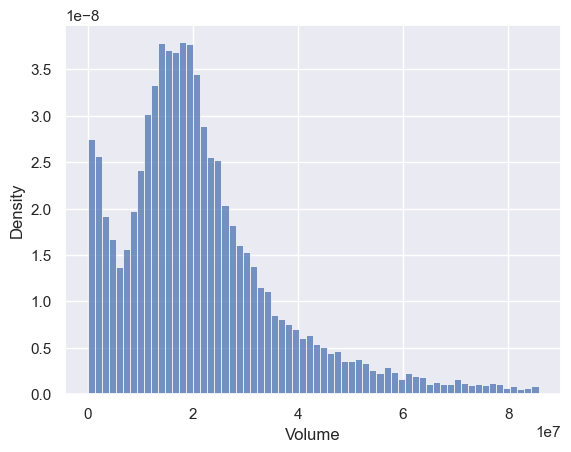

In [12]:
fig, ax = plt.subplots()

sns.histplot(volume[volume <= np.quantile(volume, 0.99)], stat='density')

Хотим построить доверительный для нашей точечной оценки

Для начала решим более простую задачу: пусть мы знаем истинное распределение, построим доверительный интервал в таких условиях. Для этого нагенерируем выборку из этого распределения кучу раз, посчитаем выборочную квантиль $\widehat{\theta}$ и запомним $\Delta = \widehat{\theta} - \theta$, где $\theta$ - истинная квантиль

Теперь посчитаем выборочные $\alpha/2, \text{ }1 - \alpha/2$ квантили в массиве из дельт, тогда доверительным интервалом для  $\theta$ будет $CI = (\widehat{\theta} - \Delta_{[1 - \alpha/2]}, \widehat{\theta} - \Delta_{[\alpha/2]})$

In [24]:
N_exps = 10_000
dist = norm()
sample_len = 100

x = dist.rvs(100)
theta = dist.ppf(0.6)
theta_estim = np.quantile(x, 0.6)

theta_estim_array = np.empty(N_exps)

for i in tqdm(range(N_exps), leave=False):
    sample = dist.rvs(sample_len)
    theta_estim_array[i] = np.quantile(sample, 0.6)

<Axes: ylabel='Density'>

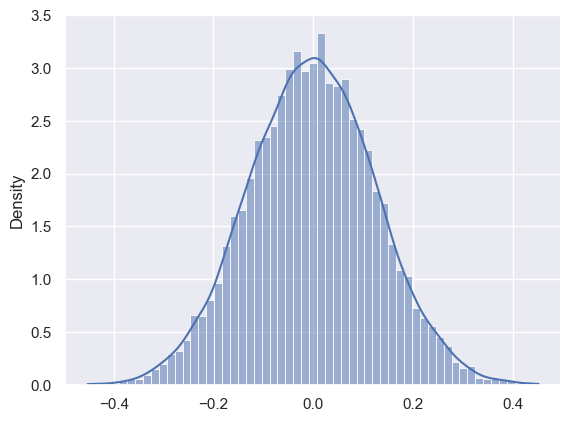

In [25]:
delta = theta_estim_array - theta
fig, ax = plt.subplots()
sns.histplot(delta, ax=ax, kde=True, stat='density')

In [26]:
alpha = 0.05
left_delta, right_delta = np.quantile(delta, [alpha/2, 1-alpha/2])

left_bound, right_bound = theta_estim - right_delta, theta_estim - left_delta
print(f"Истинное theta: {round(theta, 2)}")
print(f"Полученный CI: ({round(left_bound, 2)}, {round(right_bound, 2)})")

Истинное theta: 0.25
Полученный CI: (0.04, 0.53)


Всё хорошо, истинное значение попало в доверительный интерал, но задачу мы не решили, для выборки из начала мы не знаем истинного распределения. Идея в том чтобы заменить истинную функцию распределения на эмпирическую

Тогда мы считаем не $\Delta$ для истинного распределения, а $\Delta^*$ - та же статистика, только для св с эмпирической функцией распределения. Теперь мы делаем главное предположение метода: $\Delta \approx \Delta^*$

На бесконечности это, очевидно, верно, но на конечном числе такие вещи надо проверять методом Монте-Карло. В любом случае, добьём метод - при таком предположении доверительный интервал для статистики $\theta$ уровня значимости $\alpha$ равен $CI = (\widehat{\theta} - \Delta^*_{[1 - \alpha/2]}, \widehat{\theta} - \Delta^*_{[\alpha/2]})$

Можно не считать $\Delta^*$, а просто воспользоваться очевидной формулой $CI = (2\widehat{\theta} - \theta^*_{[1 - \alpha/2]}, 2\widehat{\theta} - \theta^*_{[\alpha/2]})$

Итак, воспользуемся методом для искусственного примера с нормальным распределением

In [27]:
theta_estim = np.quantile(x, 0.6)

theta_estim_array = np.empty(N_exps)

for i in tqdm(range(N_exps), leave=False):
    sample = np.random.choice(x, replace=True, size=sample_len)
    theta_estim_array[i] = np.quantile(sample, 0.6)

In [28]:
left_theta, right_theta = np.quantile(theta_estim_array, [alpha/2, 1-alpha/2])

left_bound = 2 * theta_estim - right_theta
right_bound = 2 * theta_estim - left_theta

print(f"Истинное theta: {round(theta, 2)}")
print(f"Полученный CI: ({round(left_bound, 2)}, {round(right_bound, 2)})")

Истинное theta: 0.25
Полученный CI: (0.04, 0.47)


Класс, всё работает

Тогда решим задачу для исходного набора данных

In [124]:
def gen_estim_theta_sample(sample_size, gen_sample_func, theta_func, N_expr=10_000):
    theta_estim_array = []
    for _ in tqdm(range(N_expr), leave=False):
        sample = gen_sample_func(sample_size)
        theta_estim_array.append(theta_func(sample))

    return theta_estim_array

In [125]:
def get_bootstrap_CI(sample, theta_func, N_expr=10000, alpha=0.05):
    theta_estim = theta_func(sample)
    gen_sample_func = lambda N: np.random.choice(sample, replace=True, size=N)

    theta_estim_array = gen_estim_theta_sample(len(sample), \
                                                gen_sample_func, theta_func, N_expr=N_expr)

    left_theta, right_theta = np.quantile(theta_estim_array, [alpha/2, 1-alpha/2])

    left_bound = 2 * theta_estim - right_theta
    right_bound = 2 * theta_estim - left_theta

    return left_bound, right_bound

In [126]:
left_bound, right_bound = get_bootstrap_CI(volume, lambda sample: np.quantile(sample, 0.6))

print(f"Эмпирическая квантиль {round(np.quantile(volume, 0.6), 2)}")
print(f"Полученный CI: ({round(left_bound, 2)}, {round(right_bound, 2)})")

Эмпирическая квантиль 21667280.0
Полученный CI: (21418960.0, 21957280.0)


In [127]:
theta_func = lambda sample: np.quantile(sample, 0.6)
%timeit get_bootstrap_CI(volume, theta_func, N_expr=2000)

775 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
theta_func = lambda sample: np.quantile(sample, 0.6)
sample = norm().rvs(100)
%timeit get_bootstrap_CI(volume, theta_func, N_expr=2000)

773 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Можно генерировать сразу несколько выборок для ускорения работы

In [129]:
def get_bootstrap_CI(sample, theta_func, N_expr=10000, alpha=0.05):
    batch_size = N_expr // 20

    theta_estim = theta_func(np.expand_dims(sample, axis=0)).ravel()[0]

    theta_estim_array = []    
    for i in tqdm(range(0, N_expr, batch_size), leave=False):
        bootstrap_sample = np.random.choice(sample, replace=True, size=(batch_size, len(sample)))
        theta_estim_array = np.concatenate([theta_estim_array, theta_func(bootstrap_sample).ravel()])

    left_theta, right_theta = np.quantile(theta_estim_array, [alpha/2, 1-alpha/2])

    left_bound = 2 * theta_estim - right_theta
    right_bound = 2 * theta_estim - left_theta

    return left_bound, right_bound

In [130]:
left_bound, right_bound = get_bootstrap_CI(volume, lambda sample: np.quantile(sample, 0.6, axis=1))

print(f"Эмпирическая квантиль {round(np.quantile(volume, 0.6), 2)}")
print(f"Полученный CI: ({round(left_bound, 2)}, {round(right_bound, 2)})")


Эмпирическая квантиль 21667280.0
Полученный CI: (21418936.0, 21951175.0)


In [131]:
theta_func = lambda sample: np.quantile(sample, 0.6, axis=1)
%timeit get_bootstrap_CI(volume, theta_func, N_expr=2000)

795 ms ± 89.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [132]:
theta_func = lambda sample: np.quantile(sample, 0.6)
sample = norm().rvs(100)
%timeit get_bootstrap_CI(volume, theta_func, N_expr=2000)

895 ms ± 84.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [142]:
#выборка маленькая, поэтому критерий, судя по всему, имеет немного завышенный fpr

positive = 0

sample_size = 1000
N_exps = 1000

dist = norm()
theta = dist.ppf(0.6)
theta_func = lambda sample: np.quantile(sample, 0.6, axis=1) 


for i in tqdm(range(N_exps)):
    sample = dist.rvs(sample_size)

    left, right = get_bootstrap_CI(sample, theta_func)

    positive += 1 - (left < theta < right)


print(f"FPR: {round(positive / N_exps, 4)}")
print(f"CI={proportion_confint(count = positive, nobs = N_exps, alpha=0.05, method='wilson')}")

100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]

FPR: 0.062
CI=(0.04866418011998063, 0.07868806031336564)


In [141]:
# огромная выбокра, fpr как заявлено
positive = 0

sample_size = 20000
N_exps = 1000

dist = gamma(a=2, scale=3)
theta = dist.ppf(0.6)
theta_func = lambda sample: np.quantile(sample, 0.6, axis=1) 


for i in tqdm(range(N_exps)):
    sample = dist.rvs(sample_size)

    left, right = get_bootstrap_CI(sample, theta_func)

    positive += 1 - (left < theta < right)


print(f"FPR: {round(positive / N_exps, 4)}")
print(f"CI={proportion_confint(count = positive, nobs = N_exps, alpha=0.05, method='wilson')}")

100%|██████████| 1000/1000 [2:04:14<00:00,  7.45s/it]   

FPR: 0.045
CI=(0.03379951228563171, 0.059682837936223455)


Самое прекрасное, что логика выше работает абсолютно для любой статистики распределения: что бы мы не захотели посчитать - пока мы умеем оценивать эту характеристику через выборки, для неё можно построить доверительный интервал

Надо помнить, что мы несколько раз использовали не точные значения тех или иных величин, а их оценки, поэтому бустрап работает если
- размер выборки достаточно большой, чтобы эмпирическая фр хорошо приближала истинную
- размер выборки в бустрапе, чтобы как можно точнее оценивать $\Delta^*$

Ещё один приятный момент: если мы хотим построить доверительный интервал для статистики, зависящей сразу от двух выборок (теста и контроля), бустрап позволяет это делать, просто нужно генерировать сразу две выборки - одну из тестового набора данных, другую из контрольного 

Есть несколько видов доверительных интервалов в бутстрапе   
1) Центральный: $CI = (2\widehat{\theta} - \theta^*_{[1 - \alpha/2]}, 2\widehat{\theta} - \theta^*_{[\alpha/2]})$
2) Нормальный: $CI = (\widehat{\theta} \pm z_{1-\alpha/2}\cdot \sqrt{S^2_{\theta^*}})$
    - Если статистика $\widehat{\theta}$ распределена нормально (что на практике практически всегда так), то мы можем посчитать по выборке $\theta^*$ стандартное отклонение $\sqrt{S^2_{\theta^*}}$. мы делаем предположение, что $\sqrt{S^2_{\theta^*}} \approx \sqrt{S^2_{\widehat{\theta}}}$ . Тогда центр распределения $\theta$ будет лежать в данном дов. интервале.
3) Процентильный: $CI = (\theta^*_{[\alpha/2]}, \theta^*_{[1 - \alpha/2]})$
    - Теоретически он работает, если существует некоторая монотонная функция $F$, такая, что $\hat U = F(\hat\theta(X_i))$ и $\hat U \sim \mathcal{N}(\varphi, c^2)$, где $\varphi = F(\theta)$. Где $X$ &mdash; выборка, $ U$ &mdash; одно наблюдение случайной величины $\hat U$.

Не буду тестить на своём железе, просто повторю выводы из курса:  
- на 5000 все дов интервалы получились корректными
- центральный интервал сходится намного дольше, чем 2 других

Так же, можно провести сравнение бутстрапа и T-testа и получить вывод о том, что T-test работает лучше  
- бустрап не работает тогда, когде не работает T-test - FPR высокий
- когда бутстрап работает - T-test тоже работает
- мощность бутстрапа не выше, чем у T-testa